# Feature extraction

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')

import utils.feature_extraction_helpers as feh
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np
import rasterio

# Set paths
data_dir = '../data/preprocessed/sentinel'
aoi_path = '../utils/AOI_bboxes/aoi_shifa.geojson'

In [35]:
# Let's check what is inside a tif file
# Path to the TIF file
tif_path = '../data/preprocessed/sentinel/20221005/20221005_sigma0_vh_db.tif'

with rasterio.open(tif_path) as src:
    # Read the data
    data = src.read(1)  # Read first band
    
    # Get metadata
    print(f"File metadata:")
    print(f"Width x Height: {src.width} x {src.height} pixels")
    print(f"Resolution: {src.res} (degrees per pixel)")
    print(f"CRS: {src.crs}")
    print(f"Transform: {src.transform}")
    
    # Data statistics
    valid_data = data[~np.isnan(data)]
    print(f"\nData statistics:")
    print(f"Valid pixels: {len(valid_data)} of {data.size} ({len(valid_data)/data.size*100:.1f}%)")
    print(f"Min: {np.nanmin(data):.3f}, Max: {np.nanmax(data):.3f}")
    print(f"Mean: {np.nanmean(data):.3f}, Median: {np.nanmedian(data):.3f}")
    
    # Plot the data
    plt.figure(figsize=(10, 10))
    plt.imshow(data, cmap='viridis')
    plt.colorbar(label='Backscatter (dB)')
    plt.title('Sentinel-1 VH Backscatter (2022-10-05)')
    plt.tight_layout()
    plt.savefig('backscatter_visualization.png')
    plt.close()
    
    # Display a histogram
    plt.figure(figsize=(10, 6))
    plt.hist(valid_data, bins=50, alpha=0.7)
    plt.title('Backscatter Distribution')
    plt.xlabel('Backscatter (dB)')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    plt.savefig('backscatter_histogram.png')
    plt.close()
    
    # Check if the resolution aligns with expected 10m Sentinel-1 resolution
    # Convert resolution to meters (approximately)
    res_in_meters = src.res[0] * 111320  # Approximate conversion at equator
    print(f"\nResolution check:")
    print(f"Resolution in meters (approximate): {res_in_meters:.2f} m")
    print(f"Is this close to 10m? {'Yes' if 9 <= res_in_meters <= 11 else 'No'}")

File metadata:
Width x Height: 1016 x 960 pixels
Resolution: (8.983152841195215e-05, 8.983152841195215e-05) (degrees per pixel)
CRS: EPSG:4326
Transform: | 0.00, 0.00, 34.41|
| 0.00,-0.00, 31.56|
| 0.00, 0.00, 1.00|

Data statistics:
Valid pixels: 975360 of 975360 (100.0%)
Min: -70.000, Max: 10.965
Mean: -34.221, Median: -17.555

Resolution check:
Resolution in meters (approximate): 10.00 m
Is this close to 10m? Yes


In [4]:
# COLLECT BACKSCATTER VALUES
# Use sample_rate < 1.0 for faster processing during development
all_backscatter = feh.collect_all_backscatter_values_optimized(data_dir, aoi_path=aoi_path, sample_rate=1)

all_backscatter.drop(columns='geometry').to_feather('../data/preprocessed/all_backscatter.feather')

Found 32 reference dates and 21 post-conflict dates
Determined orbit directions based on acquisition patterns
Processing reference dates...


  0%|          | 0/32 [00:00<?, ?it/s]

Processing post-conflict dates...


  0%|          | 0/21 [00:00<?, ?it/s]

Combining all data...
Total records: 37832684
Unique pixels: 365108

Orbit distribution:
  DESC: 18916354 observations (50.0%)
  ASC: 18916330 observations (50.0%)


In [ ]:
# LOAD BACKSCATTER VALUES
from shapely.geometry import Point

all_backscatter_loaded = pd.read_feather('../data/preprocessed/all_backscatter.feather')

all_backscatter = gpd.GeoDataFrame(
    all_backscatter_loaded, 
    geometry=[Point(xy) for xy in zip(all_backscatter_loaded.lon, all_backscatter_loaded.lat)], 
    crs="EPSG:4326"
)

In [5]:
all_backscatter.head()

,row,col,lon,lat,backscatter,date_str,backscatter_date,polarization,orbit,period,pixel_id,geometry
0,0,402,34.457964,31.551195,-70.000000,20221005,2022-10-05,VV,ASC,reference,0_402,POINT (34.45796 31.55119)
1,0,403,34.458054,31.551195,-70.000000,20221005,2022-10-05,VV,ASC,reference,0_403,POINT (34.45805 31.55119)
2,1,401,34.457874,31.551105,-16.434464,20221005,2022-10-05,VV,ASC,reference,1_401,POINT (34.45787 31.55111)
3,1,402,34.457964,31.551105,-16.049759,20221005,2022-10-05,VV,ASC,reference,1_402,POINT (34.45796 31.55111)
4,1,403,34.458054,31.551105,-11.748380,20221005,2022-10-05,VV,ASC,reference,1_403,POINT (34.45805 31.55111)


Let's conduct some sanity checks on these backscatter values

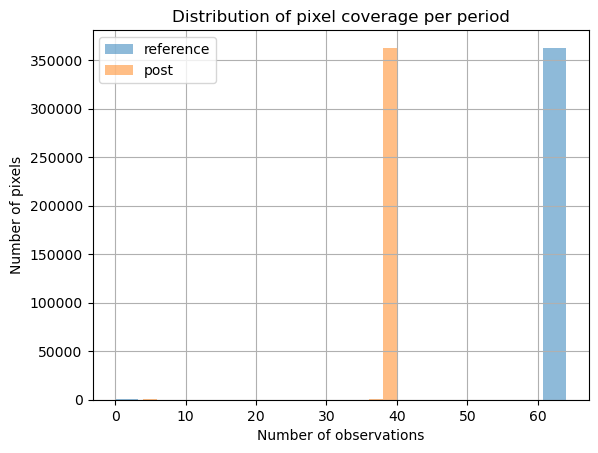

In [6]:
# Check temporal coverage per pixel
# There should be 64 (32x2) reference values and 42 (21x2) post values 
pixel_coverage = all_backscatter.groupby(['pixel_id', 'period']).size().unstack(fill_value=0)

# Distribution of pixel coverage per period
pixel_coverage['reference'].hist(bins=20, alpha=0.5, label='reference')
pixel_coverage['post'].hist(bins=20, alpha=0.5, label='post')
plt.xlabel('Number of observations')
plt.ylabel('Number of pixels')
plt.title('Distribution of pixel coverage per period')
plt.legend()

In [ ]:
# Check the spatial distribution of observation counts
pixel_counts = all_backscatter.groupby('pixel_id').size()

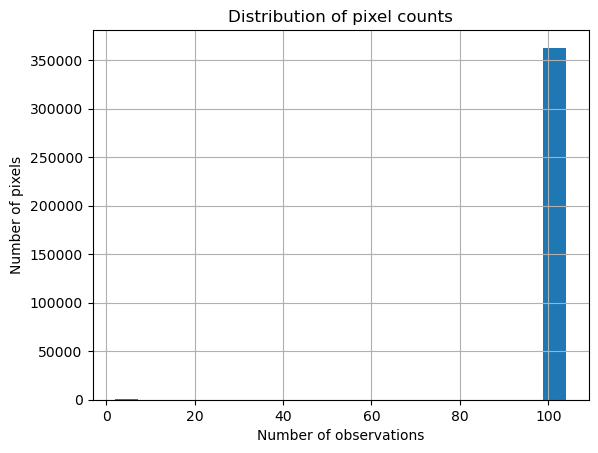

In [8]:
# Distribution of pixel counts
pixel_counts.hist(bins=20)
plt.xlabel('Number of observations')
plt.ylabel('Number of pixels')
plt.title('Distribution of pixel counts')
plt.show()

In [9]:
# Load labelled data points (data/processed/combined_damage_control_points.gpkg)
labelled_data = gpd.read_file('../data/processed/labels/combined_damage_control_points.gpkg')

In [18]:
print(labelled_data.columns)
labelled_data.head()

Index(['SiteID', 'date', 'damage_class', 'damage_status', 'Governorate',
       'Municipality', 'Neighborhood', 'damage_class_desc', 'is_damaged',
       'damage_level', 'lon', 'lat', 'index_right', 'system:index', 'area',
       'building', 'class', 'damage_pts', 'k100', 'k150', 'k50', 'max_change',
       'name', 'osm_id', 'osm_type', '.geo', 'geometry'],
      dtype='object')


,SiteID,date,damage_class,damage_status,Governorate,Municipality,Neighborhood,damage_class_desc,is_damaged,damage_level,...,damage_pts,k100,k150,k50,max_change,name,osm_id,osm_type,.geo,geometry
0,26.0,2023-11-26 00:00:00+00:00,1.0,0.0,North Gaza,Jabalya,Ar Rawdah,Destroyed,1,3.0,...,NaN,NaN,NaN,NaN,NaN,None,NaN,None,None,POINT Z (34.48112 31.51958 0)
1,26.0,2023-11-26 00:00:00+00:00,2.0,0.0,North Gaza,Jabalya,Ar Rawdah,Severe Damage,1,2.0,...,NaN,NaN,NaN,NaN,NaN,None,NaN,None,None,POINT Z (34.48139 31.51968 0)
2,26.0,2023-11-26 00:00:00+00:00,2.0,0.0,North Gaza,Jabalya,Ar Rawdah,Severe Damage,1,2.0,...,NaN,NaN,NaN,NaN,NaN,None,NaN,None,None,POINT Z (34.48091 31.5196 0)
3,26.0,2023-11-26 00:00:00+00:00,2.0,0.0,North Gaza,Jabalya,Ar Rawdah,Severe Damage,1,2.0,...,NaN,NaN,NaN,NaN,NaN,None,NaN,None,None,POINT Z (34.48206 31.51882 0)
4,26.0,2023-11-26 00:00:00+00:00,2.0,0.0,North Gaza,Jabalya,Ar Rawdah,Severe Damage,1,2.0,...,NaN,NaN,NaN,NaN,NaN,None,NaN,None,None,POINT Z (34.48198 31.5187 0)


In [19]:
def check_point_pixel_relationship(points_gdf, backscatter_gdf, buffer_distances=[0, 1, 5, 10]):
    """
    Check how many backscatter pixels are captured at different buffer distances
    
    Parameters:
    -----------
    points_gdf : GeoDataFrame
        Labeled points
    backscatter_gdf : GeoDataFrame
        Backscatter pixels
    buffer_distances : list
        Buffer distances to test in meters
        
    Returns:
    --------
    DataFrame with statistics for each buffer distance
    """
    from tqdm.notebook import tqdm
    import numpy as np
    import pandas as pd
    
    # Ensure spatial index exists for fast querying
    if not hasattr(backscatter_gdf, 'sindex') or backscatter_gdf.sindex is None:
        print("Creating spatial index for faster querying...")
        backscatter_gdf = backscatter_gdf.copy()
        backscatter_gdf.sindex  # This creates the spatial index
    
    results = []
    
    # Use a single date/polarization subset for faster processing
    sample_date = backscatter_gdf['backscatter_date'].unique()[0]
    sample_pol = backscatter_gdf['polarization'].unique()[0]
    sample_backscatter = backscatter_gdf[
        (backscatter_gdf['backscatter_date'] == sample_date) & 
        (backscatter_gdf['polarization'] == sample_pol)
    ]
    
    print(f"Using sample date {sample_date} and polarization {sample_pol} for analysis")
    
    # Convert points to appropriate CRS once
    if points_gdf.crs.is_geographic and sample_backscatter.crs.is_geographic:
        points_utm = points_gdf.to_crs("EPSG:32636")  # UTM zone 36N
    else:
        points_utm = points_gdf.to_crs(sample_backscatter.crs)
    
    for buffer_distance in buffer_distances:
        print(f"Testing buffer distance: {buffer_distance}m")
        
        # Create buffers efficiently
        buffered = points_utm.copy()
        buffered['geometry'] = points_utm.geometry.buffer(buffer_distance)
        
        # Convert back to original CRS if needed
        if points_gdf.crs.is_geographic and sample_backscatter.crs.is_geographic:
            buffered = buffered.to_crs(sample_backscatter.crs)
        
        # Count pixels within each buffer
        pixel_counts = []
        
        # Process in batches for better memory management
        batch_size = 100
        for i in tqdm(range(0, len(buffered), batch_size), desc=f"Buffer {buffer_distance}m"):
            batch = buffered.iloc[i:i+batch_size]
            
            for idx, point in batch.iterrows():
                # Use spatial index for faster querying
                possible_matches_idx = list(sample_backscatter.sindex.intersection(point.geometry.bounds))
                if possible_matches_idx:
                    possible_matches = sample_backscatter.iloc[possible_matches_idx]
                    pixels = possible_matches[possible_matches.intersects(point.geometry)]
                    
                    # Count unique pixels
                    unique_pixels = pixels['pixel_id'].nunique()
                    pixel_counts.append(unique_pixels)
                else:
                    pixel_counts.append(0)
        
        # Calculate statistics
        stats = {
            'buffer_distance': buffer_distance,
            'avg_pixels': np.mean(pixel_counts),
            'median_pixels': np.median(pixel_counts),
            'min_pixels': np.min(pixel_counts),
            'max_pixels': np.max(pixel_counts),
            'points_with_no_pixels': sum(count == 0 for count in pixel_counts),
            'points_with_one_pixel': sum(count == 1 for count in pixel_counts),
            'points_with_multiple_pixels': sum(count > 1 for count in pixel_counts),
            'total_points': len(pixel_counts)
        }
        
        # Calculate percentages
        stats['percent_with_no_pixels'] = (stats['points_with_no_pixels'] / stats['total_points']) * 100
        stats['percent_with_one_pixel'] = (stats['points_with_one_pixel'] / stats['total_points']) * 100
        stats['percent_with_multiple_pixels'] = (stats['points_with_multiple_pixels'] / stats['total_points']) * 100
        
        results.append(stats)
        
        # Print interim results
        print(f"  Average pixels per point: {stats['avg_pixels']:.2f}")
        print(f"  Points with one pixel: {stats['points_with_one_pixel']} ({stats['percent_with_one_pixel']:.1f}%)")
        print(f"  Points with multiple pixels: {stats['points_with_multiple_pixels']} ({stats['percent_with_multiple_pixels']:.1f}%)")
    
    result_df = pd.DataFrame(results)
    
    # Create a visualization of the results
    try:
        import matplotlib.pyplot as plt
        
        plt.figure(figsize=(12, 6))
        
        categories = ['points_with_no_pixels', 'points_with_one_pixel', 'points_with_multiple_pixels']
        labels = ['No pixels', 'One pixel', 'Multiple pixels']
        colors = ['red', 'green', 'blue']
        
        for i, (category, label, color) in enumerate(zip(categories, labels, colors)):
            plt.bar(
                x=np.arange(len(buffer_distances)) + (i - 1) * 0.25, 
                height=result_df[category] / result_df['total_points'] * 100,
                width=0.25,
                color=color,
                label=label
            )
        
        plt.xlabel('Buffer Distance (m)')
        plt.ylabel('Percentage of Points (%)')
        plt.title('Pixel Coverage by Buffer Distance')
        plt.xticks(np.arange(len(buffer_distances)), buffer_distances)
        plt.legend()
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()
    except:
        print("Could not create visualization. Check if matplotlib is installed.")
    
    return result_df

Using sample date 2022-10-05 00:00:00 and polarization VV for analysis
Testing buffer distance: 0m


Buffer 0m:   0%|          | 0/85 [00:00<?, ?it/s]

  Average pixels per point: 0.00
  Points with one pixel: 0 (0.0%)
  Points with multiple pixels: 0 (0.0%)
Testing buffer distance: 1m


Buffer 1m:   0%|          | 0/85 [00:00<?, ?it/s]

  Average pixels per point: 0.04
  Points with one pixel: 330 (3.9%)
  Points with multiple pixels: 0 (0.0%)
Testing buffer distance: 5m


Buffer 5m:   0%|          | 0/85 [00:00<?, ?it/s]

  Average pixels per point: 0.92
  Points with one pixel: 6766 (80.1%)
  Points with multiple pixels: 485 (5.7%)
Testing buffer distance: 10m


Buffer 10m:   0%|          | 0/85 [00:00<?, ?it/s]

  Average pixels per point: 3.70
  Points with one pixel: 0 (0.0%)
  Points with multiple pixels: 8448 (100.0%)


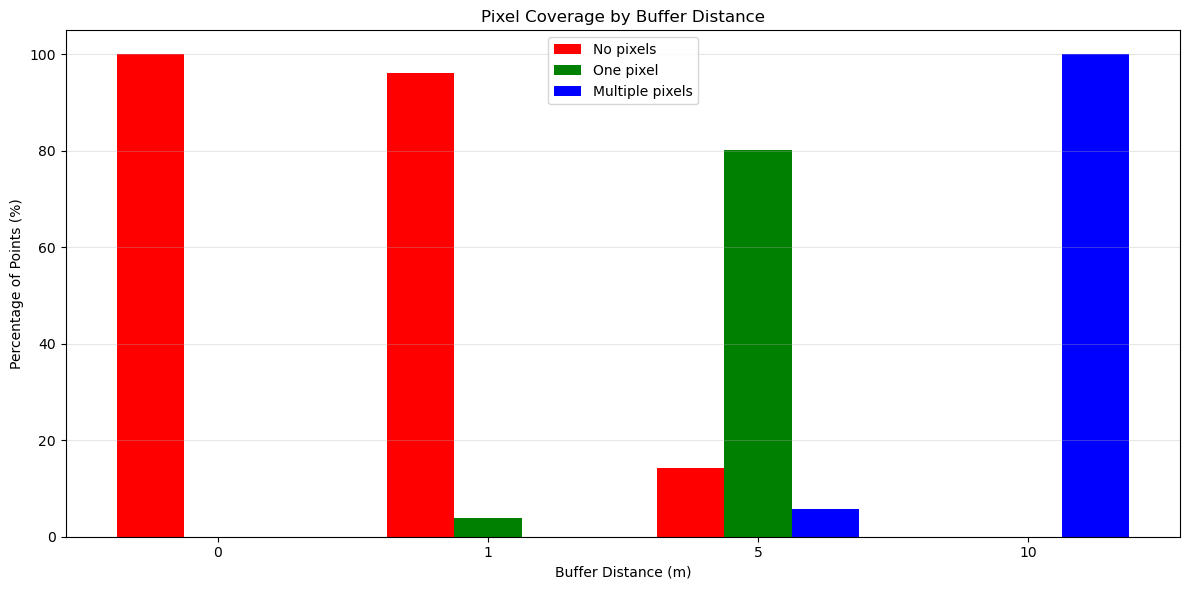

,buffer_distance,avg_pixels,median_pixels,min_pixels,max_pixels,points_with_no_pixels,points_with_one_pixel,points_with_multiple_pixels,total_points,percent_with_no_pixels,percent_with_one_pixel,percent_with_multiple_pixels
0,0,0.000000,0.0,0,0,8448,0,0,8448,100.000000,0.000000,0.000000
1,1,0.039062,0.0,0,1,8118,330,0,8448,96.093750,3.906250,0.000000
2,5,0.915720,1.0,0,2,1197,6766,485,8448,14.169034,80.089962,5.741004
3,10,3.703007,4.0,2,6,0,0,8448,8448,0.000000,0.000000,100.000000


In [20]:
check_point_pixel_relationship(labelled_data, all_backscatter, buffer_distances=[0, 1, 5, 10])

Some observations:
- At 0m buffer: Almost 100% of points have no pixels. This means virtually none of labeled points perfectly coincide with Sentinel-1 pixel centers.
- At 1m buffer: Still about 95% of points have no pixels, with only about 5% having one pixel. This suggests significant geolocation differences between labels and the Sentinel-1 pixel grid.
- At 5m buffer: The situation improves dramatically - about 80% of points capture one pixel, with about 15% still having no pixels and 5% capturing multiple pixels.
- At 10m buffer: Almost 100% of points now capture multiple pixels, with only a tiny fraction capturing just one pixel.

In [21]:
# Extract time series for each labeled point
timeseries = feh.extract_pixel_timeseries(
    labeled_points=labelled_data,
    backscatter_data=all_backscatter,
    buffer_distance=5
)

Extracting time series for 8448 points with 5m buffer...
Converting points to match backscatter CRS: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]


Extracting time series:   0%|          | 0/8448 [00:00<?, ?it/s]

Extracted 810782 time series points for 8448 labeled points
Covering 26832 unique pixels

Time series distribution by polarization and orbit:
orbit            ASC    DESC
polarization                
VH            202369  203022
VV            202369  203022


In [22]:
timeseries.to_csv('../data/preprocessed/timeseries.csv', index=False)

timeseries.columns

Index(['point_id', 'pixel_id', 'backscatter_date', 'polarization', 'orbit',
       'period', 'backscatter', 'point_lon', 'point_lat', 'pixel_lon',
       'pixel_lat', 'SiteID', 'date', 'damage_class', 'damage_status',
       'Governorate', 'Municipality', 'Neighborhood', 'damage_class_desc',
       'is_damaged', 'damage_level', 'lon', 'lat', 'index_right',
       'system:index', 'area', 'building', 'class', 'damage_pts', 'k100',
       'k150', 'k50', 'max_change', 'name', 'osm_id', 'osm_type', '.geo'],
      dtype='object')

In [24]:
timeseries.columns

Index(['point_id', 'pixel_id', 'backscatter_date', 'polarization', 'orbit',
       'period', 'backscatter', 'point_lon', 'point_lat', 'pixel_lon',
       'pixel_lat', 'SiteID', 'date', 'damage_class', 'damage_status',
       'Governorate', 'Municipality', 'Neighborhood', 'damage_class_desc',
       'is_damaged', 'damage_level', 'lon', 'lat', 'index_right',
       'system:index', 'area', 'building', 'class', 'damage_pts', 'k100',
       'k150', 'k50', 'max_change', 'name', 'osm_id', 'osm_type', '.geo'],
      dtype='object')

Let's do some checks on the timeseries data to verify the integrity of the point-to-pixel relationships and damage labels


In [25]:
# 1. Check that each point_id has only one unique is_damaged class
point_damage_consistency = timeseries.groupby('point_id')['is_damaged'].nunique()
consistent_points = (point_damage_consistency == 1).sum()
inconsistent_points = (point_damage_consistency > 1).sum()

print(f"Points with consistent damage labels: {consistent_points} ({consistent_points/len(point_damage_consistency)*100:.2f}%)")
print(f"Points with inconsistent damage labels: {inconsistent_points}")

if inconsistent_points > 0:
    print("\nInconsistent points:")
    inconsistent_point_ids = point_damage_consistency[point_damage_consistency > 1].index
    for pid in inconsistent_point_ids[:5]:  # Show first 5 examples
        damage_values = timeseries[timeseries['point_id'] == pid]['is_damaged'].unique()
        print(f"Point ID {pid}: damage values = {damage_values}")

Points with consistent damage labels: 8448 (100.00%)
Points with inconsistent damage labels: 0


In [26]:
# 2. Check how many pixels are associated with each point
pixels_per_point = timeseries.groupby('point_id')['pixel_id'].nunique()
print(f"\nPixels per point statistics:")
print(f"Mean: {pixels_per_point.mean():.2f}")
print(f"Median: {pixels_per_point.median()}")
print(f"Min: {pixels_per_point.min()}")
print(f"Max: {pixels_per_point.max()}")


Pixels per point statistics:
Mean: 3.30
Median: 3.0
Min: 2
Max: 4


In [27]:
# Distribution of pixels per point
print("\nDistribution of pixels per point:")
pixel_counts = pixels_per_point.value_counts().sort_index()
for count, freq in pixel_counts.items():
    print(f"{count} pixel(s): {freq} points ({freq/len(pixels_per_point)*100:.2f}%)")


Distribution of pixels per point:
2 pixel(s): 1621 points (19.19%)
3 pixel(s): 2635 points (31.19%)
4 pixel(s): 4192 points (49.62%)


In [33]:
# Group by point_id and backscatter_date, then count unique pixel_ids
pixel_counts_per_point_date = timeseries.groupby(['point_id', 'backscatter_date'])['pixel_id'].nunique()

# Summary statistics
print("Number of pixels per point per date:")
print(f"Mean: {pixel_counts_per_point_date.mean():.2f}")
print(f"Median: {pixel_counts_per_point_date.median()}")
print(f"Min: {pixel_counts_per_point_date.min()}")
print(f"Max: {pixel_counts_per_point_date.max()}")

# Distribution of pixel counts
print("\nDistribution of pixels per point per date:")
distribution = pixel_counts_per_point_date.value_counts().sort_index()
for count, freq in distribution.items():
    print(f"{count} pixel(s): {freq} point-date combinations ({freq/len(pixel_counts_per_point_date)*100:.2f}%)")

# Check if there are points with different numbers of pixels across dates
pixel_count_consistency = pixel_counts_per_point_date.groupby('point_id').nunique()
consistent_points = (pixel_count_consistency == 1).sum()
inconsistent_points = (pixel_count_consistency > 1).sum()

print(f"\nPoints with consistent pixel counts across all dates: {consistent_points} ({consistent_points/len(pixel_count_consistency)*100:.2f}%)")
print(f"Points with varying pixel counts across dates: {inconsistent_points} ({inconsistent_points/len(pixel_count_consistency)*100:.2f}%)")

Number of pixels per point per date:
Mean: 1.07
Median: 1.0
Min: 1
Max: 2

Distribution of pixels per point per date:
1 pixel(s): 351787 point-date combinations (92.92%)
2 pixel(s): 26802 point-date combinations (7.08%)

Points with consistent pixel counts across all dates: 221 (2.62%)
Points with varying pixel counts across dates: 8227 (97.38%)


In [34]:
# Group by point_id and count unique pixel_ids across all dates
unique_pixels_per_point = timeseries.groupby('point_id')['pixel_id'].nunique()

# Calculate how many points have exactly one pixel throughout
single_pixel_points = (unique_pixels_per_point == 1).sum()
total_points = len(unique_pixels_per_point)

print(f"Points with exactly one pixel throughout the time series: {single_pixel_points} out of {total_points}")
print(f"Percentage: {single_pixel_points/total_points*100:.2f}%")

# For points with multiple pixels, analyze the stability of the primary pixel
points_with_multiple_pixels = unique_pixels_per_point[unique_pixels_per_point > 1].index

# Analyze pixel consistency for these points
pixel_stability_results = []

for point_id in points_with_multiple_pixels:
    point_data = timeseries[timeseries['point_id'] == point_id]
    
    # Count occurrences of each pixel for this point
    pixel_counts = point_data['pixel_id'].value_counts()
    
    # Calculate total observations and observations of most frequent pixel
    total_obs = len(point_data)
    primary_pixel = pixel_counts.index[0]
    primary_pixel_count = pixel_counts.iloc[0]
    
    # Calculate stability as percentage of observations using the primary pixel
    stability = primary_pixel_count / total_obs
    
    pixel_stability_results.append({
        'point_id': point_id,
        'total_pixels': len(pixel_counts),
        'total_observations': total_obs,
        'primary_pixel': primary_pixel,
        'primary_pixel_observations': primary_pixel_count,
        'primary_pixel_percentage': stability * 100
    })

# Convert to DataFrame for analysis
stability_df = pd.DataFrame(pixel_stability_results)

# Overall statistics
print("\nFor points with multiple pixels:")
print(f"Average percentage of observations with primary pixel: {stability_df['primary_pixel_percentage'].mean():.2f}%")

# Distribution of primary pixel percentages
print("\nDistribution of primary pixel stability:")
bins = [0, 50, 60, 70, 80, 90, 95, 99, 100]
bin_labels = ['<50%', '50-60%', '60-70%', '70-80%', '80-90%', '90-95%', '95-99%', '99-100%']
stability_df['stability_bin'] = pd.cut(stability_df['primary_pixel_percentage'], bins=bins, labels=bin_labels)
stability_distribution = stability_df['stability_bin'].value_counts().sort_index()

for bin_name, count in stability_distribution.items():
    print(f"{bin_name}: {count} points ({count/len(stability_df)*100:.2f}%)")

Points with exactly one pixel throughout the time series: 0 out of 8448
Percentage: 0.00%

For points with multiple pixels:
Average percentage of observations with primary pixel: 60.72%

Distribution of primary pixel stability:
<50%: 2521 points (29.84%)
50-60%: 1946 points (23.04%)
60-70%: 1675 points (19.83%)
70-80%: 1087 points (12.87%)
80-90%: 669 points (7.92%)
90-95%: 334 points (3.95%)
95-99%: 216 points (2.56%)
99-100%: 0 points (0.00%)


In [35]:
from scipy.spatial.distance import pdist, squareform

def analyze_pixel_displacement(timeseries):
    """
    Analyze how far pixels move for each point across the time series
    """
    results = []
    
    # Process each point
    for point_id in timeseries['point_id'].unique():
        point_data = timeseries[timeseries['point_id'] == point_id]
        
        # Get unique pixel locations
        unique_pixels = point_data[['pixel_id', 'pixel_lon', 'pixel_lat']].drop_duplicates()
        
        if len(unique_pixels) <= 1:
            continue  # Skip points with only one pixel
            
        # Get the point's location
        point_location = point_data[['point_lon', 'point_lat']].iloc[0]
        
        # Calculate distance from point to each pixel (in degrees)
        unique_pixels['distance_to_point'] = np.sqrt(
            (unique_pixels['pixel_lon'] - point_location['point_lon'])**2 + 
            (unique_pixels['pixel_lat'] - point_location['point_lat'])**2
        )
        
        # Convert distance to approximate meters (very rough conversion)
        # 1 degree latitude ≈ 111km at the equator
        unique_pixels['distance_meters'] = unique_pixels['distance_to_point'] * 111000
        
        # Calculate pairwise distances between pixels
        if len(unique_pixels) >= 2:
            pixel_coords = unique_pixels[['pixel_lon', 'pixel_lat']].values
            pairwise_dist = pdist(pixel_coords)
            max_pixel_dist = np.max(pairwise_dist) * 111000  # Convert to meters
        else:
            max_pixel_dist = 0
            
        # Add results
        results.append({
            'point_id': point_id,
            'unique_pixels': len(unique_pixels),
            'max_distance_between_pixels_m': max_pixel_dist,
            'avg_distance_to_point_m': unique_pixels['distance_meters'].mean(),
            'max_distance_to_point_m': unique_pixels['distance_meters'].max()
        })
    
    results_df = pd.DataFrame(results)
    
    # Summary statistics
    print("Distance statistics:")
    print(f"Average max distance between pixels: {results_df['max_distance_between_pixels_m'].mean():.2f} meters")
    print(f"Median max distance between pixels: {results_df['max_distance_between_pixels_m'].median():.2f} meters")
    print(f"90th percentile max distance: {results_df['max_distance_between_pixels_m'].quantile(0.9):.2f} meters")
    
    print("\nDistance from point to pixels:")
    print(f"Average distance: {results_df['avg_distance_to_point_m'].mean():.2f} meters")
    print(f"Median distance: {results_df['avg_distance_to_point_m'].median():.2f} meters")
    
    # Distribution of maximum distances
    dist_bins = [0, 10, 20, 30, 40, 50, 100, float('inf')]
    results_df['distance_bin'] = pd.cut(results_df['max_distance_between_pixels_m'], bins=dist_bins)
    distance_distribution = results_df['distance_bin'].value_counts().sort_index()
    
    print("\nDistribution of maximum distance between pixels:")
    for bin_name, count in distance_distribution.items():
        print(f"{bin_name}: {count} points ({count/len(results_df)*100:.2f}%)")
    
    return results_df

In [36]:
analyze_pixel_displacement(timeseries)

Distance statistics:
Average max distance between pixels: 10.83 meters
Median max distance between pixels: 10.86 meters
90th percentile max distance: 11.28 meters

Distance from point to pixels:
Average distance: 3.62 meters
Median distance: 3.59 meters

Distribution of maximum distance between pixels:
(0.0, 10.0]: 171 points (2.02%)
(10.0, 20.0]: 8277 points (97.98%)
(20.0, 30.0]: 0 points (0.00%)
(30.0, 40.0]: 0 points (0.00%)
(40.0, 50.0]: 0 points (0.00%)
(50.0, 100.0]: 0 points (0.00%)
(100.0, inf]: 0 points (0.00%)


,point_id,unique_pixels,max_distance_between_pixels_m,avg_distance_to_point_m,max_distance_to_point_m,distance_bin
0,0,49,10.747808,3.690003,5.799422,"(10.0, 20.0]"
1,1,43,10.037810,3.631183,5.122317,"(10.0, 20.0]"
2,2,43,10.594501,3.401428,5.766728,"(10.0, 20.0]"
3,3,48,10.962149,3.576673,5.610402,"(10.0, 20.0]"
4,4,42,10.450999,3.434918,5.392114,"(10.0, 20.0]"
...,...,...,...,...,...,...
8443,8443,42,9.789715,3.558932,5.096616,"(0.0, 10.0]"
8444,8444,48,10.296142,3.503924,5.344559,"(10.0, 20.0]"
8445,8445,47,10.594768,3.571046,5.573749,"(10.0, 20.0]"
8446,8446,48,10.709521,3.444367,5.696343,"(10.0, 20.0]"


These distance statistics are very revealing. The consistent ~10.8m maximum distance between pixels confirms that points are only moving to adjacent pixels (since Sentinel-1 pixels are 10m). And with an average distance of only 3.6m from points to pixels, the geolocation is quite accurate.

In [59]:
stable_timeseries = feh.create_stable_point_timeseries(timeseries)

Selected 1 points:
Point 1552.0: Damaged, 4.2m away


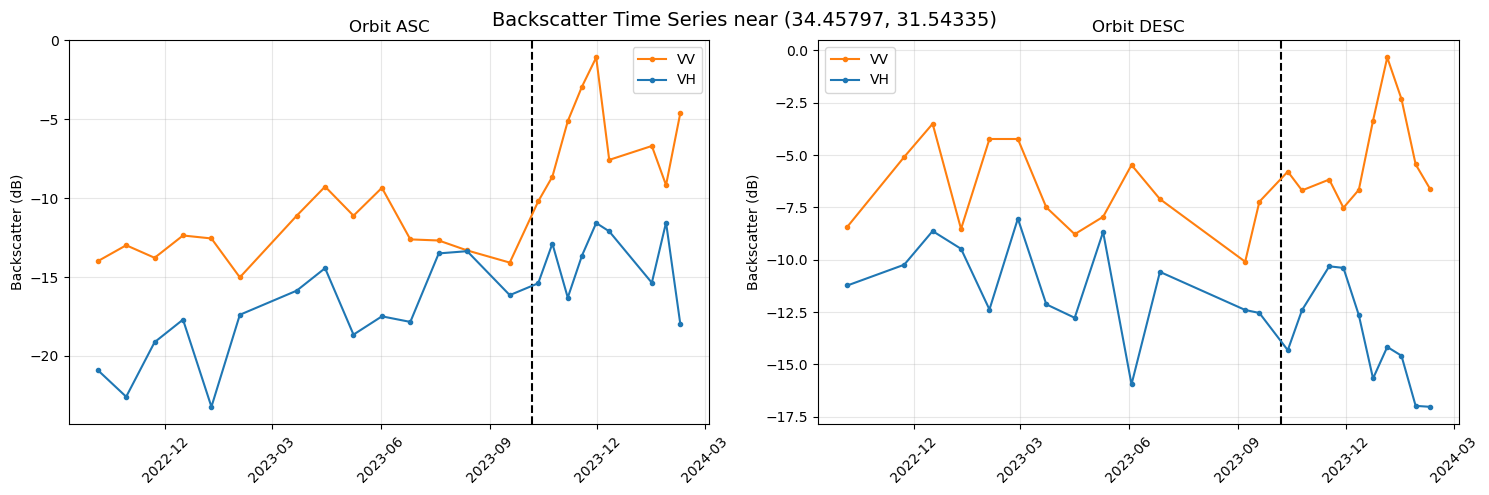

In [ ]:
from utils.visualisations_helpers import plot_backscatter_timeseries_by_id, plot_backscatter_timeseries_by_coordinates

interesting_points = {
    '2693': [34.4541552, 31.5145497],
    '2485': [34.4597159, 31.5322958],
    '223': [34.4442728, 31.5222414],
    '1552': [34.4579653, 31.5433510],
}


# Plot them
plot_backscatter_timeseries_by_coordinates(stable_timeseries,34.4579653, 31.5433510)

In [66]:
# Create feature vectors for machine learning
features = feh.create_timeseries_features(timeseries_df=timeseries)

features.to_csv('../data/processed/final/final_data.csv', index=False)

Creating time series features...
Reference period: 498808 observations
Assessment period: 311974 observations


Extracting features:   0%|          | 0/49605 [00:00<?, ?it/s]

/Users/matteolarrode/Documents/Oxford/Applied ML/Summative/ML-BuildingDamageViaSatellite/notebooks/../utils/feature_extraction_helpers.py:456: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'kurtosis': lambda x: stats.kurtosis(x) if len(x) > 3 else 0,
/Users/matteolarrode/Documents/Oxford/Applied ML/Summative/ML-BuildingDamageViaSatellite/notebooks/../utils/feature_extraction_helpers.py:457: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'skew': lambda x: stats.skew(x) if len(x) > 2 else 0


Created 36755 feature vectors
Class distribution: 18164 damaged, 18591 undamaged


In [ ]:
# Create feature vectors for machine learning
features_stable = feh.extract_ml_features_stable(stable_timeseries)

features_stable.to_csv('../data/processed/final/final_data_stable.csv', index=False)

/Users/matteolarrode/Documents/Oxford/Applied ML/Summative/ML-BuildingDamageViaSatellite/notebooks/../utils/feature_extraction_helpers.py:593: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
/Users/matteolarrode/Documents/Oxford/Applied ML/Summative/ML-BuildingDamageViaSatellite/notebooks/../utils/feature_extraction_helpers.py:594: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
/opt/anaconda3/envs/ML-summative/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/Users/matteolarrode/Documents/Oxford/Applied ML/Summative/

Extracted 121 features for 8448 points
